In order to successfully complete this assignment you must do the required reading, watch the provided videos and complete all instructions.  The embedded survey form must be entirely filled out and submitted on or before **11:59pm**.  Students must come to class the next day prepared to discuss the material covered in this assignment. 

---


# PCA 23: CUDA Alternatives

### Goals for today's pre-class assignment 

This pre-class assignment will review a few of the more common alternatives to CUDA.  

1. [OpenCL (Open Computing Language)](#OpenCL-(Open-Computing-Language))
2. [OpenACC (Open Accelerators)](#OpenACC-(Open-Accelerators))
3. [Kokkos and RAJA](#Kokkos-and-RAJA)
4. [GPU Accelerated Libraries](#GPU-Accelerated-Libraries)
5. [Assignment wrap up](#Assignment-wrap-up)






---
<a name=OpenCL-(Open-Computing-Language)></a>
# 1. OpenCL (Open Computing Language)


OpenCL is an alternative to CUDA which is designed to be more open and available on many different platforms.  Watch the following video to get some history behind OpenCL.

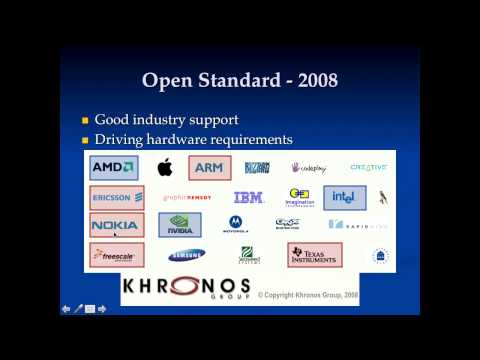

In [1]:
from IPython.display import YouTubeVideo
YouTubeVideo("V4RfPfHQPC8",width=640,height=360)

### OpenCL VectorAdd Example

&#9989; **<font color=red>DO THIS:</font>** Copy the following code to the HPC and compile/run using the commands provided below.

Example From: https://gist.github.com/ddemidov/2925717

In [ ]:
%%writefile vecAdd_opencl.c

#include <iostream>
#include <vector>
#include <string>

#define __CL_ENABLE_EXCEPTIONS
#include <CL/cl.hpp>

//Example From: https://gist.github.com/ddemidov/2925717
// Compute c = a + b.
static const char source[] =
    "#if defined(cl_khr_fp64)\n"
    "#  pragma OPENCL EXTENSION cl_khr_fp64: enable\n"
    "#elif defined(cl_amd_fp64)\n"
    "#  pragma OPENCL EXTENSION cl_amd_fp64: enable\n"
    "#else\n"
    "#  error double precision is not supported\n"
    "#endif\n"
    "kernel void add(\n"
    "       ulong n,\n"
    "       global const double *a,\n"
    "       global const double *b,\n"
    "       global double *c\n"
    "       )\n"
    "{\n"
    "    size_t i = get_global_id(0);\n"
    "    if (i < n) {\n"
    "       c[i] = a[i] + b[i];\n"
    "    }\n"
    "}\n";

int main() {
    const size_t N = 1 << 20;

    try {
	// Get list of OpenCL platforms.
	std::vector<cl::Platform> platform;
	cl::Platform::get(&platform);

	if (platform.empty()) {
	    std::cerr << "OpenCL platforms not found." << std::endl;
	    return 1;
	}

	// Get first available GPU device which supports double precision.
	cl::Context context;
	std::vector<cl::Device> device;
	for(auto p = platform.begin(); device.empty() && p != platform.end(); p++) {
	    std::vector<cl::Device> pldev;

	    try {
		p->getDevices(CL_DEVICE_TYPE_GPU, &pldev);

		for(auto d = pldev.begin(); device.empty() && d != pldev.end(); d++) {
		    if (!d->getInfo<CL_DEVICE_AVAILABLE>()) continue;

		    std::string ext = d->getInfo<CL_DEVICE_EXTENSIONS>();

		    if (
			    ext.find("cl_khr_fp64") == std::string::npos &&
			    ext.find("cl_amd_fp64") == std::string::npos
		       ) continue;

		    device.push_back(*d);
		    context = cl::Context(device);
		}
	    } catch(...) {
		device.clear();
	    }
	}

	if (device.empty()) {
	    std::cerr << "GPUs with double precision not found." << std::endl;
	    return 1;
	}

	std::cout << device[0].getInfo<CL_DEVICE_NAME>() << std::endl;

	// Create command queue.
	cl::CommandQueue queue(context, device[0]);

	// Compile OpenCL program for found device.
	cl::Program program(context, cl::Program::Sources(
		    1, std::make_pair(source, strlen(source))
		    ));

	try {
	    program.build(device);
	} catch (const cl::Error&) {
	    std::cerr
		<< "OpenCL compilation error" << std::endl
		<< program.getBuildInfo<CL_PROGRAM_BUILD_LOG>(device[0])
		<< std::endl;
	    return 1;
	}

	cl::Kernel add(program, "add");

	// Prepare input data.
	std::vector<double> a(N, 1);
	std::vector<double> b(N, 2);
	std::vector<double> c(N);

	// Allocate device buffers and transfer input data to device.
	cl::Buffer A(context, CL_MEM_READ_ONLY | CL_MEM_COPY_HOST_PTR,
		a.size() * sizeof(double), a.data());

	cl::Buffer B(context, CL_MEM_READ_ONLY | CL_MEM_COPY_HOST_PTR,
		b.size() * sizeof(double), b.data());

	cl::Buffer C(context, CL_MEM_READ_WRITE,
		c.size() * sizeof(double));

	// Set kernel parameters.
	add.setArg(0, static_cast<cl_ulong>(N));
	add.setArg(1, A);
	add.setArg(2, B);
	add.setArg(3, C);
	
	// Launch kernel on the compute device.
	queue.enqueueNDRangeKernel(add, cl::NullRange, N, cl::NullRange);

	// Get result back to host.
	queue.enqueueReadBuffer(C, CL_TRUE, 0, c.size() * sizeof(double), c.data());

	// Should get '3' here.
	std::cout << c[42] << std::endl;
    } catch (const cl::Error &err) {
	std::cerr
	    << "OpenCL error: "
	    << err.what() << "(" << err.err() << ")"
	    << std::endl;
	return 1;
    }
}

In [ ]:
!module load cuda
!g++ -std=c++0x -lOpenCL -o opencl NCode/vecAdd_opencl.c

In [ ]:
!time ./opencl

&#9989; **<font color=red>QUESTION:</font>**  Where you able to get the OpenCL code to compile and run?

No.

&#9989; **<font color=red>QUESTION:</font>**  If not, what problems did you encounter?

It produced a bunch of compilation errors and warnings.



---
<a name=OpenACC-(Open-Accelerators)></a>
# 2. OpenACC (Open Accelerators)



The next programming extension is called OpenACC and tries to combine the ease of programming in OpenMP with the power of the GPU.  It uses pragmas similar to OpenMP to compile and run code on the GPU.

&#9989; **<font color=red>DO THIS:</font>** Copy the following code to the HPC and compile/run using the commands provided below.

Example From: https://www.olcf.ornl.gov/tutorials/openacc-vector-addition/

In [ ]:
%%writefile vecAdd_openacc.cu

#include <stdio.h>
#include <stdlib.h>
#include <math.h>
 
//Example From: https://www.olcf.ornl.gov/tutorials/openacc-vector-addition/
int main( int argc, char* argv[] )
{
 
    // Size of vectors
    int n = 10000;
 
    // Input vectors
    double *restrict a;
    double *restrict b;
    // Output vector
    double *restrict c;
 
    // Size, in bytes, of each vector
    size_t bytes = n*sizeof(double);
 
    // Allocate memory for each vector
    a = (double*)malloc(bytes);
    b = (double*)malloc(bytes);
    c = (double*)malloc(bytes);
 
    // Initialize content of input vectors, vector a[i] = sin(i)^2 vector b[i] = cos(i)^2
    int i;
    for(i=0; i<n; i++) {
        a[i] = sin(i)*sin(i);
        b[i] = cos(i)*cos(i);
    }  
 
    // sum component wise and save result into vector c
    #pragma acc kernels copyin(a[0:n],b[0:n]), copyout(c[0:n])
    for(i=0; i<n; i++) {
        c[i] = a[i] + b[i];
    }
 
    // Sum up vector c and print result divided by n, this should equal 1 within error
    double sum = 0.0;
    for(i=0; i<n; i++) {
        sum += c[i];
    }
    sum = sum/n;
    printf("final result: %f\n", sum);
 
    // Release memory
    free(a);
    free(b);
    free(c);
 
    return 0;
}

In [ ]:
!module swap GNU PGI

In [ ]:
!pgcc -acc -o openacc vecAdd_OpenACC.c

In [ ]:
!time ./openacc

&#9989; **<font color=red>QUESTION:</font>**  Where you able to get the OpenACC code to compile and run?

No.

&#9989; **<font color=red>QUESTION:</font>**  If not, what problems did you encounter?

module swap GNU PGI didn't work as GNU was not on the box. module load PGI also didn't work.



---
<a name=Kokkos-and-RAJA></a>
# 3. Kokkos and RAJA



Two newcomers to the playing field are Kokkos and RAJA.  Neither are new languages but instead a C++ library intended to make it easier to run both OpenMP and GPU code.  The goal of both programs is to:

1. Enable application portability with manageable disruption to algorithms and programming styles.
2. Achieve performance comparable to using various programming models (e.g., OpenMP, CUDA, etc.) directly

These two goals are very difficult.  However, both projects seem to be getting close. It will be interesting to see which one "wins".

* For more information on how to run Kokkos on the HPC follow the instructions found here: https://www.egr.msu.edu/nextgen/wiki/index.php/Kokkos

* I have not tried getting RAJA to work yet but here is some information on the project:
https://media.readthedocs.org/pdf/raja/master/raja.pdf

&#9989; **<font color=red>QUESTION:</font>** Why you think there are so many alternatives to CUDA (provide at least two reasons)?

Because CUDA is managed by one company as opposed to by multiple companies and because it's complicated enough to warrant the desire for simpler alternatives.


---
<a name=GPU-Accelerated-Libraries></a>
# 4. GPU Accelerated Libraries

Another way to avoid having to write your own CUDA code is to use CUDA Accelerated libraries. As a programmer you don't need to do anything except include the libraries and call the CUDA enabled functions.  


&#9989; **<font color=red>DO THIS:</font>** Using your favorite search engine, find some common CUDA enabled libraries for Fast Fourier Transforms, Dense Linear Algebra and Sparse Linear Algebra

cuFFT, CUTLASS, cuSPARSE

&#9989; **<font color=red>DO THIS:</font>** See if you can find other CUDA enabled libraries that you think could be useful.  Come to class prepared to share what you found.

nvJPEG - a high-performance GPU-accelerated library for decoding, encoding and transcoding JPEG format images.



---
<a name=Assignment-wrap-up></a>
# 5. Assignment wrap up

Please fill out the form that appears when you run the code below.  **You must completely fill this out in order to receive credits for the assignment!**

[Direct Link to Survey Form](https://cmse.msu.edu/cmse401-pc-survey)


&#9989; **<font color=red>Assignment-Specific QUESTION:</font>** Why you think there are so many alternatives to CUDA (provide at least two reasons)?

Because CUDA is managed by one company as opposed to by multiple companies and because it's complicated enough to warrant the desire for simpler alternatives.

&#9989; **<font color=red>QUESTION:</font>**  Summarize what you did in this assignment.

Explored CUDA alternatives

&#9989; **<font color=red>QUESTION:</font>**  What questions do you have, if any, about any of the topics discussed in this assignment after working through the jupyter notebook?

How do I get the sample code to work

&#9989; **<font color=red>QUESTION:</font>**  How well do you feel this assignment helped you to achieve a better understanding of the above mentioned topic(s)?

decent

&#9989; **<font color=red>QUESTION:</font>** What was the **most** challenging part of this assignment for you? 

Getting the sample code to work

&#9989; **<font color=red>QUESTION:</font>** What was the **least** challenging part of this assignment for you? 

Searching for CUDA libraries

&#9989; **<font color=red>QUESTION:</font>**  What kind of additional questions or support, if any, do you feel you need to have a better understanding of the content in this assignment?

none

&#9989; **<font color=red>QUESTION:</font>**  Do you have any further questions or comments about this material, or anything else that's going on in class?

no

&#9989; **<font color=red>QUESTION:</font>** Approximately how long did this pre-class assignment take?

hour

In [21]:
from IPython.display import HTML
HTML(
"""
<iframe 
	src="https://cmse.msu.edu/cmse401-pc-survey" 
	width="100%" 
	height="500px" 
	frameborder="0" 
	marginheight="0" 
	marginwidth="0">
	Loading...
</iframe>
"""
)

###STARTFOOTER###

---------
### Congratulations, we're done!

To get credit for this assignment you must fill out and submit the above survey from on or before the assignment due date.

### Course Resources:

###LINKS###

In [ ]:
##ANSWER## 
#this cell gets the name of the current notebook.
from jupyterinstruct import InstructorNotebook
InstructorNotebook.cleanNsave()

import thiscourse
tags = thiscourse.tags()
##ANSWER## 

In [ ]:
##ANSWER## 
#This cell runs the converter which removes ANSWER feilds, renames the notebook and cleans out output fields. 
studentnotebook = InstructorNotebook.makestudent(this_notebook, "./"+tags['COURSE_CODE']+"/", tags)
InstructorNotebook.validate(studentnotebook)
##ANSWER## 

In [ ]:
##ANSWER##
from jupyterinstruct import webtools

webtools.publish2folder(studentnotebook, './cmse401-S21-student/assignments')

##ANSWER##

In [ ]:
##ANSWER##
from jupyterinstruct import InstructorNotebook

InstructorNotebook.cleanNsave()
##ANSWER##

Written by Dr. Dirk Colbry, Michigan State University
<a rel="license" href="http://creativecommons.org/licenses/by-nc/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-nc/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-nc/4.0/">Creative Commons Attribution-NonCommercial 4.0 International License</a>.

----

----